In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as c
import pickle

import sys

In [173]:
%time
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 6 15:25:33 2018

@author: sritee
"""
#Orienteering problem with Miller-Tucker-Zemlin formulation

def get_cvx_solver_solution(nodes_list, budget, cost_matrix, origin_index):
    origin_index = 0
    num_nodes= len(nodes_list) #number of nodes in the Orienteering

    total_time= budget

    score_vector=np.ones((num_nodes)) #this will generate a random score matrix.
    score_vector[0]=0 #since the 0th node, start node, has no value!

    x=c.Variable((num_nodes,num_nodes),boolean=True) #x_ij is 1, if we travel from i to j in the tour.

    u=c.Variable(num_nodes) #variables in subtour elimination constraints


    cost=c.trace(c.matmul(cost_matrix.T,x)) #total cost of the tour
    profit=c.sum(c.matmul(x,score_vector))

    ones_arr=np.ones([num_nodes]) #array for ones
    ones_arr[origin_index] = 0
    constraints=[]

    #now, let us make sure each node is visited only once, and we leave only once from that node.

    constraints.append(c.sum(x[origin_index,:])==1)  #we leave from the first node
    constraints.append(c.sum(x[:,origin_index])==1) #we come back to the first node

    constraints.append(c.matmul(x.T,ones_arr)<=1)  #max one connection outgoing and incoming
    constraints.append(c.matmul(x,ones_arr)<=1)

    for i in range(1,num_nodes):
        constraints.append(c.sum(x[:,i])==c.sum(x[i,:]))
    #let us add the time constraints

    constraints.append(cost<=total_time)
    constraints.append(profit<=len(nodes_list))
    #Let us add the subtour elimination constraints (Miller-Tucker-Zemlin similar formulation)

    for i in range(1,num_nodes):
        for j in range(1,num_nodes):
            if i!=j:
                constraints.append((u[i]-u[j]+num_nodes*x[i,j]-num_nodes+1<=0))
            else:
                continue

    prob=c.Problem(c.Maximize(profit),constraints)

    prob.solve()

    if np.any(x.value==None): #no feasible solution found!

        print('Feasible solution not found, lower your time constraint!') 

    #print(x.value.astype('int32'))
    #print(cost_matrix)

    print(origin_index)
    tour=[origin_index] #.the final tour we have found will be stored here. Initialize with start node.
    verified_cost=0 #builds up the cost of the tour, independently from the gurobi solver. We use this as a sanity check.

    now_node=origin_index #Initialize at start node


    while(1): #till we reach end node

        next_node=np.argmax(x.value[now_node,:]) #where  we go from node i
        verified_cost=verified_cost+cost_matrix[now_node,next_node] #build up the cost
        tour.append(next_node) #for 1 based indexing
        now_node=next_node
        if next_node==origin_index: #we have looped again
            break

    print('Profit of tour found by the solver is {}, cost of it is {}, and cost computed by us for verification is {} '.format(round(prob.value,2),cost.value,round(verified_cost,2)))
    print('tour: ', tour[:-1])
    return tour[:-1]

def get_list_of_index_tuples(dim_1=24, dim_2=24):
    index_tuples = []
    for j in range(dim_2):
        for i in range(dim_1):
            index_tuples.append((i,j))
    return index_tuples

def get_nodes_and_edges_list_for_graph(Image, list_of_index_tuples):    
    dim_1, dim_2 = Image.shape
    nodes_list = []
    edges_list = []
    for i, p_1 in enumerate(list_of_index_tuples):
        if(Image[p_1]):
            nodes_list.append(p_1)
            
        for j, p_2 in enumerate(nodes_list):
            diff = np.abs(np.array(p_1)-np.array(p_2)).sum()
            
            if(diff==1 and Image[p_1] and Image[p_2]):
                edges_list.append((p_1, p_2))

    return nodes_list, edges_list      

def get_index(nodes_list, origin):
    for i in range(len(nodes_list)):
        if(nodes_list[i]==origin):
            return i
    return -1    

def get_cost_matrix(G, nodes_list, origin_index):
    origin_index = 0
    cost_matrix = np.zeros((len(nodes_list), len(nodes_list)))
    for i,n1 in enumerate(nodes_list):
        for j,n2 in enumerate(nodes_list):
            if(i!=j): #and np.abs(np.array(n1)-np.array(n2)).sum()<=1):
                if(j==origin_index):
                    cost_matrix[(i,j)] = 0
                else:    
                    cost_matrix[(i,j)] = nx.shortest_path_length(G, n1, n2)
            else:    
                cost_matrix[(i,j)] = 1000
    return cost_matrix  

def get_path_from_indices(G, nodes_list, indices):
    result = []
    retraced_indicator = []
    for i, idx in enumerate(indices):
        if(i==0):
            result.append(nodes_list[idx])
            retraced_indicator.append(0)
            prev_node = result[-1]
            
        elif(np.abs(np.array(prev_node) - np.array(nodes_list[idx])).sum()>1):
            retracing_path = nx.shortest_path(G, prev_node, nodes_list[idx])
            
            for j in range(1, len(retracing_path)):
                retraced_indicator.append(retracing_path[j] in result)
                result.append(retracing_path[j])
                
            retraced_indicator[-1] = 0
            prev_node = result[-1]
            
        else:
            retraced_indicator.append(nodes_list[idx] in result)
            result.append(nodes_list[idx])
            prev_node = result[-1]
    return result, retraced_indicator

def plot_cur_pos_with_retraced(cur, prev, axes, retraced_indicator):    
    direction = np.array(cur) - np.array(prev)    
    if(retraced_indicator):
        axes.arrow(prev[1],prev[0], direction[1], direction[0], color='g', ls='--', width=0.05)
    else:    
        axes.arrow(prev[1],prev[0], direction[1], direction[0], color='b', ls='--', width=0.1)
    
def plot_path_with_retraced(Image, origin, dest, path, retraced_indicator):
    fig, axes = plt.subplots(1,1, figsize=(12,12))
    axes.imshow(Image, cmap='gray')
    axes.plot(origin[1], origin[0], marker="s", color="r",markersize=20)
    axes.plot(dest[1], dest[0], marker="*", color="g", markersize=20)

    for i in range(1, len(path)):
        plot_cur_pos_with_retraced(path[i], path[i-1], axes, retraced_indicator[i])

    plt.show()        

def plot_cur_pos(cur, prev, axes):    
    direction = np.array(cur) - np.array(prev)    
    axes.arrow(prev[1],prev[0], direction[1], direction[0], color='b', ls='--', width=0.1)
    
def plot_path(Image, origin, dest, path):
    fig, axes = plt.subplots(1,1, figsize=(12,12))
    axes.imshow(Image, cmap='gray')
    axes.plot(origin[1], origin[0], marker="s", color="r",markersize=20)
    axes.plot(dest[1], dest[0], marker="*", color="g", markersize=20)

    for i in range(1, len(path)):
        plot_cur_pos(path[i], path[i-1], axes)

    plt.show()          

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [113]:
favorite_color = pickle.load( open( "synthetic_data/variable/image_dataset_24.pickle", "rb" ) )

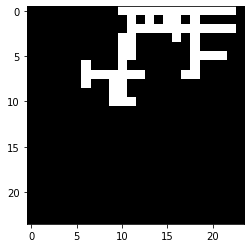

In [114]:
rand_idx = np.random.randint(0, len(favorite_color['train']))
test_image = favorite_color['train'][rand_idx]
plt.imshow(test_image, cmap="gray")

In [160]:

#dest = (3, 3)

G = nx.Graph()
list_of_index_tuples = get_list_of_index_tuples(test_image.shape[0], test_image.shape[0])
nodes_list, edges_list = get_nodes_and_edges_list_for_graph(test_image, list_of_index_tuples)

#rand_idx = np.random.randint(0, )
origin = nodes_list[0]
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)
origin_index = get_index(nodes_list, origin)
cost_matrix = get_cost_matrix(G, nodes_list, origin_index)

In [172]:
len(nodes_list)

63

In [182]:
tour = get_cvx_solver_solution(nodes_list, 90, cost_matrix, origin_index)
resultant_path, retraced_indicator = get_path_from_indices(G, nodes_list, tour)
plot_path_with_retraced(test_image, origin, resultant_path[-1], resultant_path, retraced_indicator)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [71]:
import gurobipy as grb
import math

n = len(nodes_list)
Distance = 5
opt_model = grb.Model(name="Orienteering Problem")

# <= Variables
x_vars = {}
for i in range(n):
    for j in range(n):
        x_vars[i,j] = opt_model.addVar(vtype=grb.GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))
u={}
for i in range(1,n):
    u[i]=opt_model.addVar(vtype=grb.GRB.INTEGER,
                          name='e'+str(i))

for i in range(n-1):
    opt_model.addConstr(grb.quicksum(x_vars[i,j]*cost_matrix[(i,j)] for j in range(1,n)) <= Distance)
    
# <= Constraint (Mandatory Edges and excluding vertexes) Eq(1)


opt_model.addConstr((grb.quicksum(x_vars[1,j] for j in range(1,n)))  == 1)
opt_model.addConstr((grb.quicksum(x_vars[i,n-1] for i in range(n-1))) == 1)
opt_model.addConstr((grb.quicksum(x_vars[i,i] for i in range(n-1)))  == 0)
# <= Constraint (Distance) Eq(3)





# <= Constraint (Equality & Single edge in and out) Eq(2)

for k in range(1, n-1):
    opt_model.addConstr(grb.quicksum(x_vars[i,k] for i in range(n-1)) == grb.quicksum(x_vars[k,j] for j in range(1, n)))  
    opt_model.addConstr(grb.quicksum(x_vars[i,k] for i in range(n-1))<=1)
    opt_model.addConstr(grb.quicksum(x_vars[k,j] for j in range(1, n))<=1)
                    

# <= Constraint (Subtour elimination) Eq(4) Eq(5)

for i in range(1,n):
    opt_model.addConstr(2 <= u[i])
    opt_model.addConstr(u[i] <= n)

for i in range(1,n):
    for j in range(1,n):
        opt_model.addConstr((u[i] - u[j] +1 <= (n-1)*(1-x_vars[j,i])))

# <= objective (maximize) Eq(1)

objective = grb.quicksum(x_vars[i,j]
                         for i in range(1, n-1)
                         for j in range(1, n))

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)
opt_model.optimize()

print('Obj: %g' % opt_model.objVal)

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 135 rows, 109 columns and 623 nonzeros
Model fingerprint: 0x1eaf00a6
Variable types: 0 continuous, 109 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 50 rows and 33 columns
Presolve time: 0.00s
Presolved: 85 rows, 76 columns, 416 nonzeros
Variable types: 0 continuous, 76 integer (68 binary)

Root relaxation: objective 8.000000e+00, 36 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       8.0000000   53.00000   562%     -    0s
     0     0          -    0         8.00000    8.00000  0.00%     -    0s

Explored 0 nodes (74 simplex iterations) in 0.01 seconds
Thre

In [72]:
select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)

In [73]:
select

<gurobi.tuplelist (9 tuples, 2 values each):
 ( 0 , 4 )
 ( 1 , 3 )
 ( 2 , 1 )
 ( 3 , 6 )
 ( 4 , 5 )
 ( 5 , 8 )
 ( 6 , 9 )
 ( 7 , 2 )
 ( 8 , 7 )
>

In [74]:
def get_path(tupleslist, budget, cost_matrix):
    path = {}
    indices = []
    for n1,n2 in tupleslist:
        path[n1] = n2
    accumulated_cost = 0    
    start_node = 0
    indices.append(start_node)
    
    while(accumulated_cost<=budget and start_node<len(tupleslist)):
        indices.append(path[start_node])
        accumulated_cost += cost_matrix[(start_node, path[start_node])]
        start_node = path[start_node]
        
        print(indices)
    return indices    

In [75]:
res = get_path(select, 20, cost_matrix)

[0, 4]
[0, 4, 5]
[0, 4, 5, 8]
[0, 4, 5, 8, 7]
[0, 4, 5, 8, 7, 2]
[0, 4, 5, 8, 7, 2, 1]
[0, 4, 5, 8, 7, 2, 1, 3]
[0, 4, 5, 8, 7, 2, 1, 3, 6]
[0, 4, 5, 8, 7, 2, 1, 3, 6, 9]


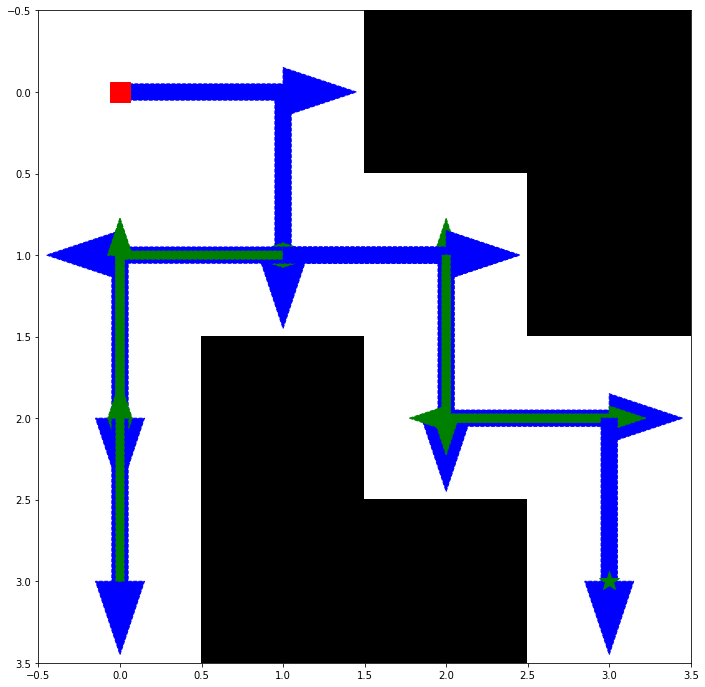

In [76]:
resultant_path, retraced_indicator = get_path_from_indices(G, nodes_list, res)
plot_path_with_retraced(image_5x5, origin, resultant_path[-1], resultant_path, retraced_indicator)

In [77]:
resultant_path

[(0, 0),
 (0, 1),
 (1, 1),
 (1, 2),
 (2, 2),
 (2, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (1, 0),
 (2, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (2, 0),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 2),
 (2, 3),
 (3, 3)]